In [1]:
import pandas as pd
import numpy as np
from utils.dates import create_cal_data
from utils.column_mapping import map_columns
from aggregation import compute_average_loadshapes
import matplotlib.pyplot as plt
import os, sys

In [3]:
sector = 'com'

if sector=='res':
    #ResStock outputs
    base_dir = r"G:\Shared drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\ResStock"
    indir = os.path.join(base_dir,r"2012 AMY (December 28)\EEDR Results 2020-12-21(8784 hours)\building_load_shapes")
else:
    #ComStock outputs
    base_dir = r'G:\Shared drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\ComStock'
    #indir = os.path.join(base_dir, r'2012_ComStock(01 04 2021 from Andrew)\timeseries_weighted\building_load_shapes')
    indir = os.path.join(base_dir, r'FullData(12 07 2020 from Andrew)\timeseries_unweighted\building_load_shapes')

In [4]:
files = pd.read_csv(os.path.join(indir,'file_names.txt'), sep=':', header=None, index_col=0)

In [5]:
lshp = pd.read_csv(os.path.join(indir, files[1].values[400].strip()+'.csv'), index_col=0)
lshp.head()

cooling  exterior_lighting       fans  heat_recovery  heat_rejection  \
0  0.021866          41.978219   2.917666            0.0             0.0   
1  0.005915          41.978219   1.357102            0.0             0.0   
2  0.017310          41.978219   2.266705            0.0             0.0   
3  0.058830          41.978219   6.625868            0.0             0.0   
4  0.157269          41.978219  19.840325            0.0             0.0   

     heating  humidification  interior_equipment  interior_lighting     pumps  \
0   0.370599             0.0           36.629409          13.109407  0.000193   
1   0.295362             0.0           40.207223          12.585357  0.000000   
2   0.314184             0.0           42.702415          13.626735  0.000000   
3   4.948752             0.0           43.751823          15.422957  0.000000   
4  47.447786             0.0           48.523366          19.048895  0.001253   

   refrigeration  water_systems       total  
0            0.0        0.00000   95.027359  
1            0.0        0.00000   96.429178  
2            0.0        0.71884  101.624408  
3            0.0        0.00000  112.786449  
4            0.0        3.55820  180.555311

In [6]:
col_map = pd.read_csv(os.path.join(base_dir,'drpath column mapping.csv'))
col_map = col_map.loc[col_map.iloc[:,1]!='total']
col_map#.iloc[:,0]#head()
map_columns(lshp, col_map, map_to=3)

Cooling   Lighting  HVAC System    Heating  Interior equipment  \
0     0.021866  55.087626     2.917858   0.370599           36.629409   
1     0.005915  54.563576     1.357102   0.295362           40.207223   
2     0.017310  55.604955     2.266705   0.314184           42.702415   
3     0.058830  57.401176     6.625868   4.948752           43.751823   
4     0.157269  61.027114    19.841577  47.447786           48.523366   
...        ...        ...          ...        ...                 ...   
8755  0.741343  92.821706    13.998080   0.410275           40.917021   
8756  0.157182  83.918846     5.333221   0.472919           36.272736   
8757  0.007098  78.086886     2.217072   0.336882           35.812759   
8758  0.000971  69.074695     0.299239   0.000000           35.788710   
8759  0.002299  63.108307     0.038785   0.000000           35.954742   

      Refrigeration  Water Heating  
0               0.0       0.000000  
1               0.0       0.000000  
2               0.0       0.718840  
3               0.0       0.000000  
4               0.0       3.558200  
...             ...            ...  
8755            0.0       9.472127  
8756            0.0       9.246118  
8757            0.0       8.258708  
8758            0.0       5.216534  
8759            0.0       3.461636  

[8760 rows x 7 columns]

In [7]:
caldat = create_cal_data(start_date='01-01-2016', end_date='01-01-2017')
caldat

C:\Users\bgerke\code\bto-task-2\loadshapes\utils\dates.py:55: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  caldat['week'] = caldat['timestamp'].dt.week


timestamp  dow  dom  doy  week  month  dhour  quarter  season  \
0    2016-01-01 00:00:00    4    1    1    53      1      0        1       1   
1    2016-01-01 01:00:00    4    1    1    53      1      1        1       1   
2    2016-01-01 02:00:00    4    1    1    53      1      2        1       1   
3    2016-01-01 03:00:00    4    1    1    53      1      3        1       1   
4    2016-01-01 04:00:00    4    1    1    53      1      4        1       1   
...                  ...  ...  ...  ...   ...    ...    ...      ...     ...   
8779 2016-12-31 19:00:00    5   31  366    52     12     19        4       1   
8780 2016-12-31 20:00:00    5   31  366    52     12     20        4       1   
8781 2016-12-31 21:00:00    5   31  366    52     12     21        4       1   
8782 2016-12-31 22:00:00    5   31  366    52     12     22        4       1   
8783 2016-12-31 23:00:00    5   31  366    52     12     23        4       1   

      weekend  yhour  
0           0      0  
1           0      1  
2           0      2  
3           0      3  
4           0      4  
...       ...    ...  
8779        1   8779  
8780        1   8780  
8781        1   8781  
8782        1   8782  
8783        1   8783  

[8784 rows x 11 columns]

In [8]:
eu_cols = lshp.columns[~lshp.columns.isin(['epw', 'unit_type', 'upgrade', 'time', 
                                            'Building_Electricity', 'Interior_Equipment'])].values
eu_cols

array(['cooling', 'exterior_lighting', 'fans', 'heat_recovery',
       'heat_rejection', 'heating', 'humidification',
       'interior_equipment', 'interior_lighting', 'pumps',
       'refrigeration', 'water_systems', 'total'], dtype=object)

In [9]:
avg_lshp = compute_average_loadshapes(pd.concat([caldat,lshp], axis='columns'), by='season', cols=eu_cols)
avg_lshp

season  dhour    cooling  exterior_lighting       fans  heat_recovery  \
0        1      0   0.052605          41.978219   0.662988            0.0   
1        1      1   0.010637          41.978219   0.423228            0.0   
2        1      2   0.007367          41.978219   0.470527            0.0   
3        1      3   0.182031          41.978219   1.715408            0.0   
4        1      4   0.472630          41.978219   9.882673            0.0   
..     ...    ...        ...                ...        ...            ...   
91       4     19  24.285231          48.016487  19.302577            0.0   
92       4     20  18.560189          48.016487  15.277430            0.0   
93       4     21   7.210298          48.016487   8.119578            0.0   
94       4     22   6.033927          48.016487   6.751049            0.0   
95       4     23   4.160167          43.504375   5.205208            0.0   

    heat_rejection    heating  humidification  interior_equipment  \
0              0.0   0.103266             0.0           33.995615   
1              0.0   0.103848             0.0           36.539838   
2              0.0   0.126895             0.0           38.314197   
3              0.0   1.216905             0.0           39.060443   
4              0.0  10.386685             0.0           42.467451   
..             ...        ...             ...                 ...   
91             0.0   0.025065             0.0           34.637405   
92             0.0   0.027154             0.0           33.527166   
93             0.0   0.028458             0.0           33.428551   
94             0.0   0.012441             0.0           33.511636   
95             0.0   0.016134             0.0           33.898521   

    interior_lighting     pumps  refrigeration  water_systems       total  
0           12.928012  0.000137            0.0       1.156509   90.877350  
1           12.555354  0.000000            0.0       0.343594   91.954718  
2           13.295890  0.000000            0.0       0.333387   94.526481  
3           14.573203  0.000000            0.0       0.865236   99.591445  
4           17.151648  0.000891            0.0       2.332796  124.672992  
..                ...       ...            ...            ...         ...  
91          30.873857  0.002981            0.0       6.347033  163.490635  
92          26.134487  0.002970            0.0       6.413823  147.959706  
93          20.291316  0.001939            0.0       4.557426  121.654054  
94          15.460615  0.000988            0.0       2.502425  112.289567  
95          13.300346  0.000306            0.0       1.143128  101.228184  

[96 rows x 15 columns]

In [10]:
#Get unique buildings

buildings = files[1].str.strip().str.split('-').str.slice(stop=-1).str.join('-').unique()
buildings


array(['LA_Fort.Polk.Army-FullServiceRestaurant-2A',
       'LA_Fort.Polk.Army-PrimarySchool-2A',
       'LA_Fort.Polk.Army-SecondarySchool-2A', ...,
       'CA_Bishop.Airport-SecondarySchool-6B',
       'CA_Bishop.Airport-SmallHotel-6B', 'CA_Lake.Tahoe-SmallHotel-6B'],
      dtype=object)

In [12]:
if sector=='res':
    upgrades = ['upgrade_0', 'upgrade_1', 'upgrade_2', 'upgrade_3','upgrade_4','upgrade_5']
else:
    upgrades = ['baseline', 'equipment_only','controls_only', 'envelope_only',
                'envelope_plus_controls','envelope_plus_controls_plus_equipment']

In [13]:
def plot_building_load_by_season_upgrade(name, close=True, save=True):
    '''
    Plot seasonal load profiles for a given building and weather station, for all five upgrades
    '''
    seasons=['winter','spring','summer', 'fall']
    upgrade_names=['base','equip.', 'contr.', 'env.', 'contr.+env.', 'all']
    fig, axs = plt.subplots(6,4, figsize=(18,15), sharex=True, sharey=True)
    for j in range(0,6):
        file = name+'-'+upgrades[j]+'.csv'
        lshp = map_columns(pd.read_csv(os.path.join(indir,file)), col_map, map_to=2)
        eu_cols=lshp.columns
        avg_lshp = compute_average_loadshapes(pd.concat([caldat,lshp], axis='columns'), by='season', cols=eu_cols)
        for i in range(4):
            sel = avg_lshp['season']==i+1
            avg_lshp.loc[sel, ['dhour']+list(eu_cols)].plot.area(x='dhour', ax=axs[j][i], 
                                                                 grid=True, legend=False)
            axs[j][i].set_axisbelow(True)
            if j==0:
                axs[j][i].set_ylim([0, avg_lshp.loc[:,eu_cols].sum(axis=1).max()*1.1])
                axs[j][i].set_title(seasons[i], fontsize=22)
            if j==5:
                axs[j][i].set_xlabel('Hour of day', fontsize=18)
        axs[j][i].text(0.9,0.87,upgrade_names[j], transform=axs[j][i].transAxes, fontsize=20, ha='right')
        axs[j][0].set_ylabel('kWh/h', fontsize=18)
    fig.suptitle(name, fontsize=24)
    axs[0][3].legend(loc='upper left', bbox_to_anchor=[1,1.04], fontsize=22)
    if save: fig.savefig(os.path.join(indir,'seasonal_plots', name+'.png'), bbox_inches='tight')
    if close: plt.close(fig)
    

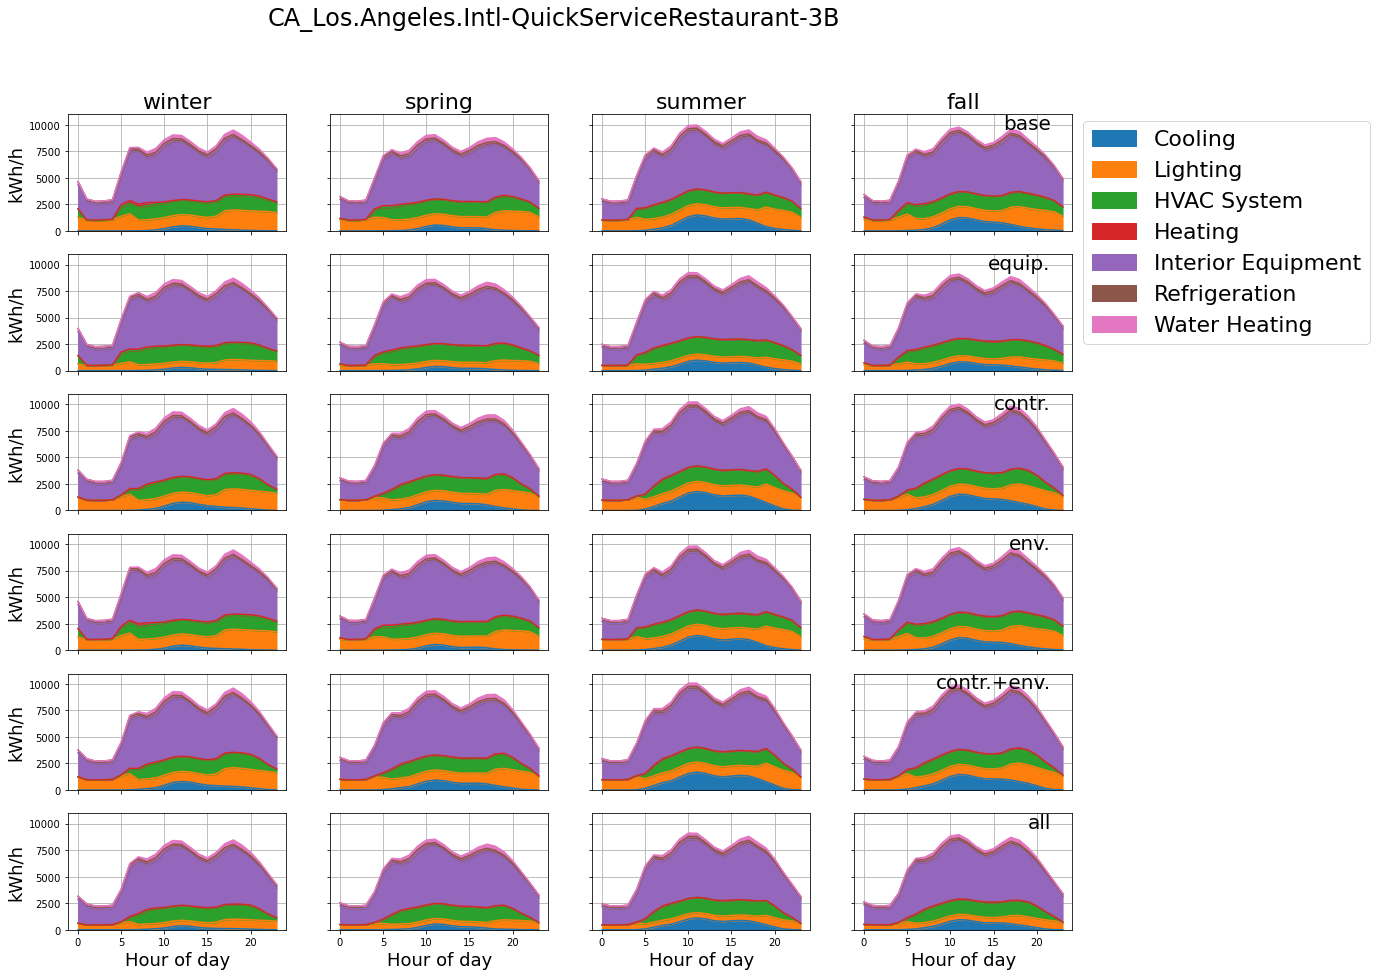

In [22]:
plot_building_load_by_season_upgrade('CA_Los.Angeles.Intl-QuickServiceRestaurant-3B', close=False, save=False)

In [24]:
for b in buildings:
    plot_building_load_by_season_upgrade(b)
